In [1]:
# import os
## Do not preallocate GPU memory
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = '\"platform\"'

from nodax import *
# jax.config.update("jax_debug_nans", True)




#%%

## Hyperparams

# ## Take seed as a paramter with argparse !! ONLY during testing.
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--seed", type=int, default=1176)
# seed = parser.parse_args().seed

seed = 2026

ncf_sample_size = 1               ## Number of neighboring contexts j to use for a flow in env e
context_size = 1024
nb_epochs = 24000*1
nb_epochs_adapt = 24000

print_error_every = 1000

train = False
save_trainer = True

finetune = False
# run_folder = "./runs/27012024-155719/"      ## Only needed if not training

adapt = False
adapt_huge = False


############# Inductive Bias Learning for Dynamical Systems #############

Jax version: 0.4.23
Available devices: [cuda(id=0)]


In [2]:
if train == True:

    # check that 'tmp' folder exists. If not, create it
    if not os.path.exists('./runs'):
        os.mkdir('./runs')

    # Make a new folder inside 'tmp' whose name is the current time
    run_folder = './runs/'+time.strftime("%d%m%Y-%H%M%S")+'/'
    # run_folder = "./runs/23012024-163033/"
    os.mkdir(run_folder)
    print("Data folder created successfuly:", run_folder)

    # Save the run and dataset scripts in that folder
    script_name = os.path.basename(__file__)
    os.system(f"cp {script_name} {run_folder}")
    os.system(f"cp dataset.py {run_folder}")

    # Save the nodax module files as well
    os.system(f"cp -r ../../nodax {run_folder}")
    print("Completed copied scripts ")


else:
    run_folder = "./runs/17022024-105655/"  ## Needed for loading the model and finetuning TODO: opti
    print("No training. Loading data and results from:", run_folder)

## Create a folder for the adaptation results
adapt_folder = run_folder+"adapt/"
if not os.path.exists(adapt_folder):
    os.mkdir(adapt_folder)

No training. Loading data and results from: ./runs/17022024-105655/


In [3]:
if train == True:
    # Run the dataset script to generate the data
    os.system(f'python dataset.py --split=train --savepath="{run_folder}" --seed="{seed}"')
    os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}"')
if adapt == True:
    os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}"');
if adapt_huge == True:
    os.system(f'python dataset.py --split=adapt_huge --savepath="{adapt_folder}" --seed="{seed*4}"');

In [4]:
## Define dataloader for training
train_dataloader = DataLoader(run_folder+"train_data.npz", batch_size=4, int_cutoff=0.25, shuffle=True, key=seed)

nb_envs = train_dataloader.nb_envs
nb_trajs_per_env = train_dataloader.nb_trajs_per_env
nb_steps_per_traj = train_dataloader.nb_steps_per_traj
data_size = train_dataloader.data_size

In [5]:
## Define model and loss function for the learner

activation = jax.nn.softplus
# activation = jax.nn.swish


class Augmentation(eqx.Module):
    layers_data: list
    layers_context: list
    layers_shared: list

    def __init__(self, data_size, width_size, depth, context_size, key=None):
        keys = generate_new_keys(key, num=12)
        self.layers_data = [eqx.nn.Linear(data_size, width_size//4, key=keys[0]), activation,
                        eqx.nn.Linear(width_size//4, width_size, key=keys[10]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[1]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[2])]

        self.layers_context = [eqx.nn.Linear(context_size, context_size//4, key=keys[3]), activation,
                        eqx.nn.Linear(context_size//4, width_size, key=keys[11]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[4]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[5])]

        self.layers_shared = [eqx.nn.Linear(width_size*2, int(width_size*1.5), key=keys[6]), activation,
                        eqx.nn.Linear(int(width_size*1.5), width_size, key=keys[7]), activation,
                        eqx.nn.Linear(width_size, width_size, key=keys[8]), activation,
                        eqx.nn.Linear(width_size, data_size, key=keys[9])]


    def __call__(self, t, x, ctx):
        y = x
        ctx = ctx
        for i in range(len(self.layers_data)):
            y = self.layers_data[i](y)
            ctx = self.layers_context[i](ctx)

        y = jnp.concatenate([y, ctx], axis=0)
        # y = jnp.dstack([y,ctx]).ravel()
        for layer in self.layers_shared:
            y = layer(y)
        return y

class ContextFlowVectorField(eqx.Module):
    physics: eqx.Module
    augmentation: eqx.Module

    def __init__(self, augmentation, physics=None):
        self.augmentation = augmentation
        # self.physics = physics if physics is not None else NoPhysics()
        self.physics = physics

    # def __call__(self, t, x, ctxs):
    #     if self.physics is None:
    #         vf = lambda xi_: self.augmentation(t, x, xi_)
    #     else:
    #         vf = lambda xi_: self.physics(t, x, xi_) + self.augmentation(t, x, xi_)

    #     gradvf = lambda xi_, xi: eqx.filter_jvp(vf, (xi_,), (xi-xi_,))[1]

    #     ctx, ctx_ = ctxs
    #     return vf(ctx_) + gradvf(ctx_, ctx)

    def __call__(self, t, x, ctxs):
        if self.physics is None:
            vf = lambda xi_: self.augmentation(t, x, xi_)
        else:
            vf = lambda xi_: self.physics(t, x, xi_) + self.augmentation(t, x, xi_)
        ctx, ctx_ = ctxs
        return vf(ctx)

augmentation = Augmentation(data_size=2, width_size=64, depth=4, context_size=context_size, key=seed)

vectorfield = ContextFlowVectorField(augmentation, physics=None)
print("\n\nTotal number of parameters in the model:", sum(x.size for x in jax.tree_util.tree_leaves(eqx.filter(vectorfield,eqx.is_array)) if x is not None), "\n\n")

contexts = ContextParams(nb_envs, context_size, key=None)

# integrator = diffrax.Tsit5()  ## Has to conform to my API
# integrator = rk4_integrator
integrator = diffrax.Dopri5()


# ## Define a custom loss function here
# def loss_fn_ctx(model, trajs, t_eval, ctx, alpha, beta, ctx_, key):

#     trajs_hat, nb_steps = jax.vmap(model, in_axes=(None, None, None, 0))(trajs[:, 0, :], t_eval, ctx, ctx_)
#     new_trajs = jnp.broadcast_to(trajs, trajs_hat.shape)

#     term1 = jnp.mean((new_trajs-trajs_hat)**2)  ## reconstruction
#     # term1 = jnp.mean(jnp.abs(new_trajs-trajs_hat))  ## reconstruction
#     # term1 = jnp.mean(jnp.abs(new_trajs-trajs_hat)/new_trajs)  ## MAPE

#     # term2 = 1e-3*jnp.mean((ctx)**2)             ## regularisation
#     term2 = jnp.mean(jnp.abs(ctx))             ## regularisation

#     loss_val = term1 + 0*term2

#     return loss_val, (jnp.sum(nb_steps)/ctx_.shape[0], term1, term2)


## Define a custom loss function here
def loss_fn_ctx(model, trajs, t_eval, ctx, all_ctx_s, key):

    # ind = jax.random.randint(key, shape=(ncf_sample_size,), minval=0, maxval=all_ctx_s.shape[0])
    ind = jax.random.permutation(key, all_ctx_s.shape[0])[:ncf_sample_size]
    ctx_s = all_ctx_s[ind, :]

    # jax.debug.print("indices chosen for this loss {}", ind)

    trajs_hat, nb_steps = jax.vmap(model, in_axes=(None, None, None, 0))(trajs[:, 0, :], t_eval, ctx, ctx_s)
    new_trajs = jnp.broadcast_to(trajs, trajs_hat.shape)

    term1 = jnp.mean((new_trajs-trajs_hat)**2)  ## reconstruction
    # term1 = jnp.mean(jnp.abs(new_trajs-trajs_hat))  ## reconstruction
    # term1 = jnp.mean(jnp.abs(new_trajs-trajs_hat)/new_trajs)  ## MAPE

    # term2 = 1e-3*jnp.mean((ctx)**2)             ## regularisation
    term2 = jnp.mean(jnp.abs(ctx))             ## regularisation

    # loss_val = term1 + 0*term2
    loss_val = term1

    return loss_val, (jnp.sum(nb_steps)/ctx_s.shape[0], term1, term2)




learner = Learner(vectorfield, contexts, loss_fn_ctx, integrator, key=seed)



Total number of parameters in the model: 319506 




In [6]:
## Define optimiser and traine the model

nb_total_epochs = nb_epochs * 1
sched_node = optax.piecewise_constant_schedule(init_value=1e-3,
                        boundaries_and_scales={nb_total_epochs//3:0.1, 2*nb_total_epochs//3:0.1})

sched_ctx = optax.piecewise_constant_schedule(init_value=1e-3,
                        boundaries_and_scales={nb_total_epochs//3:0.1, 2*nb_total_epochs//3:0.1})

opt_node = optax.adabelief(sched_node)
opt_ctx = optax.adabelief(sched_ctx)

trainer = Trainer(train_dataloader, learner, (opt_node, opt_ctx), key=seed)

In [7]:
trainer_save_path = run_folder if save_trainer == True else False
if train == True:
    # for propostion in [0.25, 0.5, 0.75]:
    for i, prop in enumerate(np.linspace(1.0, 1.0, 1)):
        trainer.dataloader.int_cutoff = int(prop*nb_steps_per_traj)
        trainer.train(nb_epochs=nb_epochs*(2**0), print_error_every=print_error_every*(2**0), update_context_every=1, save_path=trainer_save_path, key=seed)

else:
    # print("\nNo training, attempting to load model and results from "+ run_folder +" folder ...\n")

    restore_folder = run_folder
    # restore_folder = "./runs/27012024-155719/finetune_193625/"
    trainer.restore_trainer(path=restore_folder)


No training, loading model and results from ./runs/17022024-105655/ folder ...



In [8]:
if finetune:
    # ## Finetune a trained model

    finetunedir = run_folder+"finetune_"+trainer.dataloader.data_id+"/"
    if not os.path.exists(finetunedir):
        os.mkdir(finetunedir)
    print("No training. Loading anctx_sd finetuning into:", finetunedir)

    trainer.dataloader.int_cutoff = nb_steps_per_traj

    opt_node = optax.adabelief(1e-7)
    opt_ctx = optax.adabelief(1e-7)
    trainer.opt_node, trainer.opt_ctx = opt_node, opt_ctx

    # trainer.opt_node_state = trainer.opt_node.init(eqx.filter(trainer.learner.neuralode, eqx.is_array))
    # trainer.opt_ctx_state = trainer.opt_ctx.init(trainer.learner.contexts)

    trainer.train(nb_epochs=24000, print_error_every=1000, update_context_every=1, save_path=finetunedir, key=seed)

==  Begining in-domain testing ... ==
    Number of training environments: 9
    Final length of the training trajectories: 5
    Length of the testing trajectories: 20
Test Score (In-Domain): 0.00012321104

==  Begining in-domain visualisation ... ==
    Environment id: 8
    Trajectory id: 9
    Final length of the training trajectories: 5
    Length of the testing trajectories: 20
Testing finished. Figure saved in: ./runs/17022024-105655/results_in_domain.png


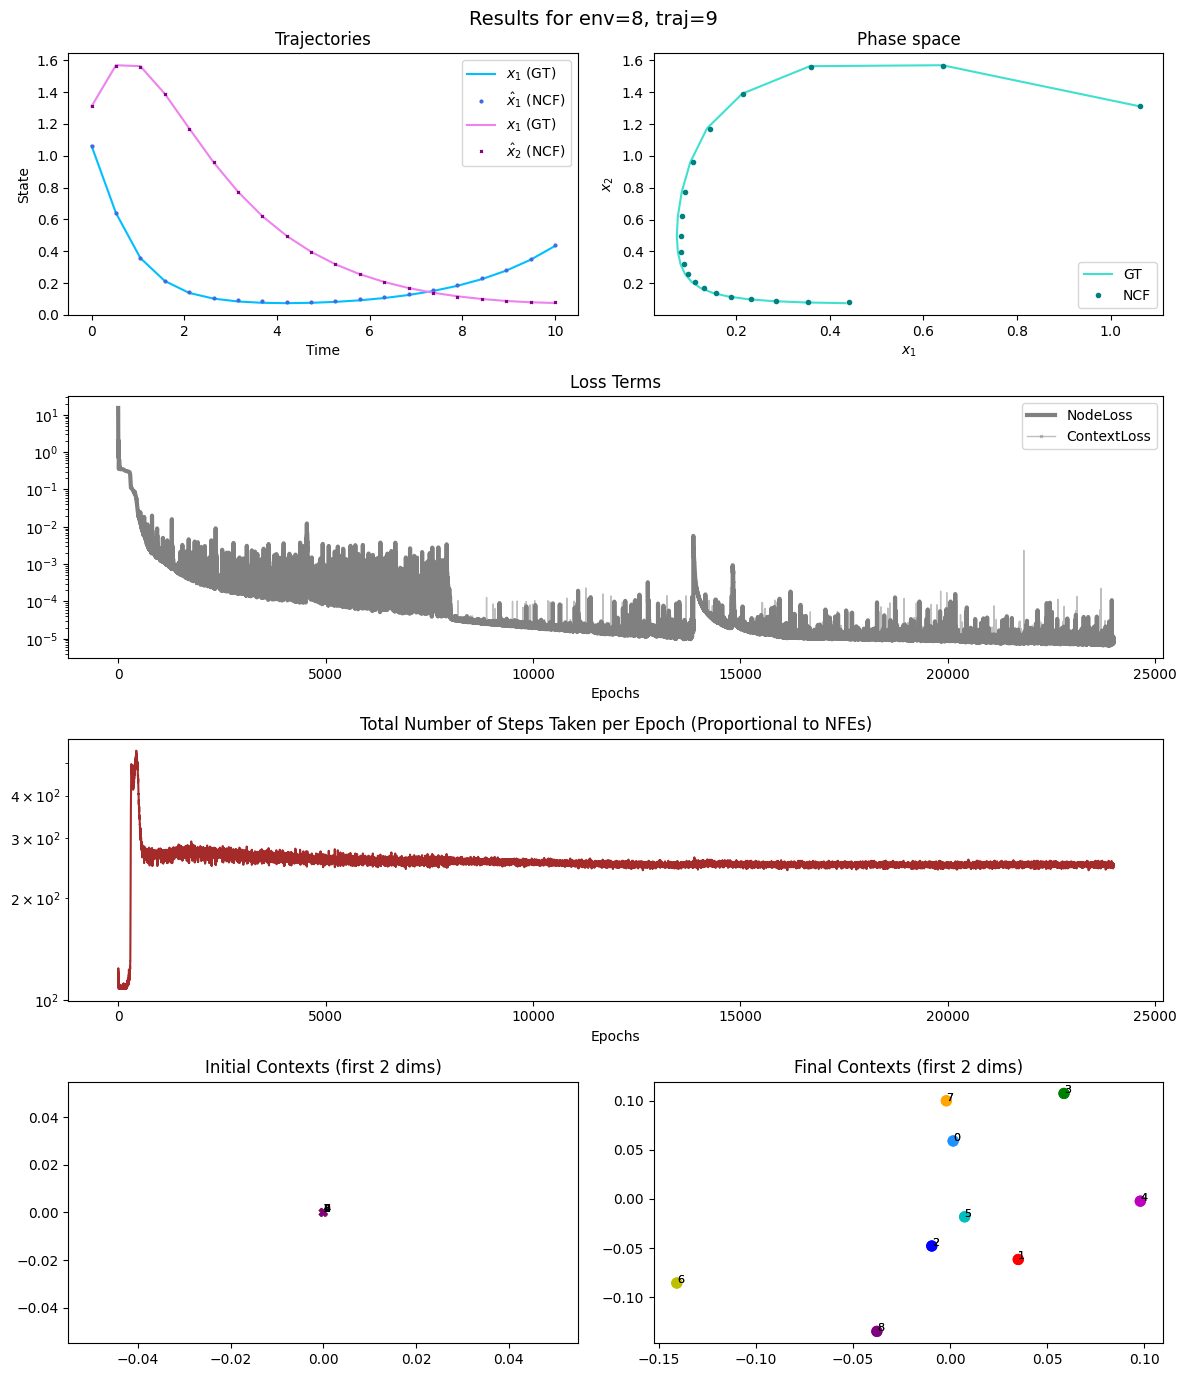

In [9]:
## Test and visualise the results on a test dataloader

test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)

visualtester = VisualTester(trainer)
# ans = visualtester.trainer.nb_steps_node
# print(ans.shape)

ind_crit = visualtester.test(test_dataloader, int_cutoff=1.0)

if finetune:
    savefigdir = finetunedir+"results_in_domain.png"
else:
    savefigdir = run_folder+"results_in_domain.png"
visualtester.visualize(test_dataloader, int_cutoff=1.0, save_path=savefigdir);

In [10]:
# len(trainer.losses_node

# ## Run and get the contexts
# for i in range(nb_envs):
#     ctx = trainer.learner.contexts.params[i]
#     # print(ctx)
#     param = ctx
#     for layer in trainer.learner.physics.layers_context:
#         param = layer(param)
#         # print("Context", ctx, "     Param", param)
#     param = jnp.abs(param)
#     print("Param:", param)

In [11]:
## Give the dataloader an id to help with restoration later on

adapt_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, data_id="170846", key=seed)

# sched_ctx_new = optax.piecewise_constant_schedule(init_value=1e-5,
#                         boundaries_and_scales={int(nb_epochs_adapt*0.25):1.,
#                                                 int(nb_epochs_adapt*0.5):0.1,
#                                                 int(nb_epochs_adapt*0.75):1.})
sched_ctx_new = optax.piecewise_constant_schedule(init_value=1e-3,
                        boundaries_and_scales={nb_total_epochs//3:0.1, 2*nb_total_epochs//3:0.1})
# sched_ctx_new = 1e-5
opt_adapt = optax.adabelief(sched_ctx_new)

if adapt == True:
    trainer.adapt(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
else:
    print("save_id:", adapt_dataloader.data_id)

    trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)

save_id: 170846

No adaptation, loading adaptation parameters from ./runs/17022024-105655/adapt/ folder with id: 170846 ...



==  Begining out-of-distribution testing ... ==
    Number of training environments: 9
    Number of adaptation environments: 4
    Final length of the training trajectories: 5
    Length of the testing trajectories: 20
Test Score (OOD): 0.00084175036

==  Begining out-of-distribution visualisation ... ==
    Environment id: 3
    Trajectory id: 0
    Final length of the training trajectories: 5
    Length of the testing trajectories: 20
Testing finished. Figure saved in: ./runs/17022024-105655/adapt/results_ood.png


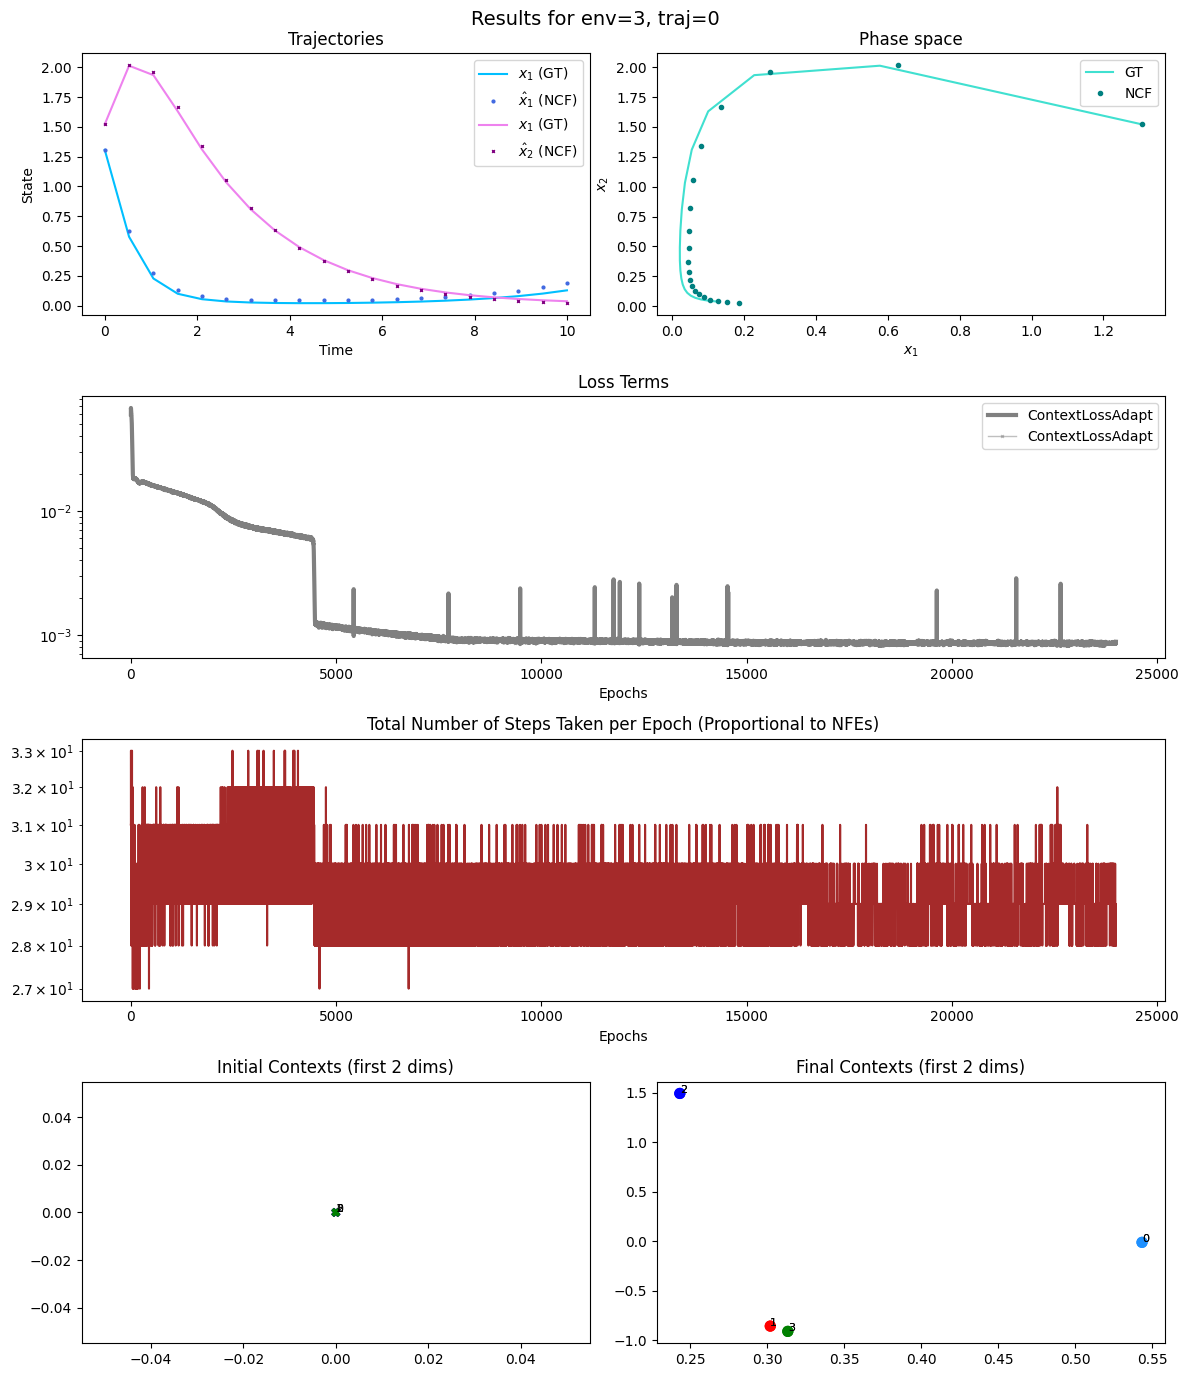

In [12]:
ood_crit = visualtester.test(adapt_dataloader, int_cutoff=1.0)      ## It's the same visualtester as before during training. It knows trainer

visualtester.visualize(adapt_dataloader, int_cutoff=1.0, save_path=adapt_folder+"results_ood.png");

In [13]:
# eqx.tree_deserialise_leaves(run_folder+"contexts.eqx", learner.contexts)

In [14]:
#### Generate data for analysis


# ## We want to store 3 values in a CSV file: "seed", "ind_crit", and "ood_crit", into the test_scores.csv file


# print("\nFull evaluation of the model on 10 random seeds\n", flush=True)

# # First, check if the file exists. If not, create it and write the header
# if not os.path.exists(run_folder+'analysis'):
#     os.mkdir(run_folder+'analysis')

# csv_file = run_folder+'analysis/test_scores.csv'
# if not os.path.exists(csv_file):
#     os.system(f"touch {csv_file}")

# with open(csv_file, 'r') as f:
#     lines = f.readlines()
#     if len(lines) == 0:
#         with open(csv_file, 'w') as f:
#             f.write("seed,ind_crit,ood_crit\n")


# ## Get results on test and adaptation datasets, then append them to the csv

# np.random.seed(seed)
# seeds = np.random.randint(0, 10000, 10)
# for seed in seeds:
# # for seed in range(8000, 6*10**3, 10):
#     os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}" --verbose=0')
#     os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}" --verbose=0')

#     test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False, batch_size=4, data_id="082026")
#     adapt_test_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, batch_size=1, key=seed, data_id="082026")

#     ind_crit, _ = visualtester.test(test_dataloader, int_cutoff=1.0, verbose=False)
#     ood_crit, _ = visualtester.test(adapt_test_dataloader, int_cutoff=1.0, verbose=False)

#     with open(csv_file, 'a') as f:
#         f.write(f"{seed},{ind_crit},{ood_crit}\n")


# ## Print the mean and stds of the scores
# import pandas as pd
# pd.set_option('display.float_format', '{:.2e}'.format)
# test_scores = pd.read_csv(csv_file).describe()
# print(test_scores.iloc[:3])

In [15]:
## Huge adaptation step to 51*51 environments and MAPE score computation



## Give the dataloader an id to help with restoration later on



# adapt_dataloader = DataLoader(adapt_folder+"adapt_huge_data.npz", adaptation=True, data_id="090142", key=seed)

# sched_ctx_new = optax.piecewise_constant_schedule(init_value=1e-3,
#                         boundaries_and_scales={nb_epochs_adapt//3:0.1, 2*nb_epochs_adapt//3:0.1})
# opt_adapt = optax.adabelief(sched_ctx_new)

# # nb_epochs_adapt = 2
# if adapt_huge == True:
#     trainer.adapt(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
# else:
#     print("save_id:", adapt_dataloader.data_id)

#     trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)

# ## Define mape criterion over a trajectory
# def mape(y, y_hat):
#     norm_traget = jnp.abs(y)
#     norm_diff = jnp.abs(y-y_hat)
#     ratios = jnp.mean(norm_diff/norm_traget, axis=-1)
#     return jnp.sum(ratios)

# ood_crit, odd_crit_all = visualtester.test(adapt_dataloader, criterion=mape)
# visualtester.visualize(adapt_dataloader, int_cutoff=1.0, save_path=adapt_folder+"results_ood_huge.png");

# print(odd_crit_all)

# ## Save the odd_crit_all in numpy
# np.save(adapt_folder+'mapes.npy', odd_crit_all)

In [16]:
## If the nohup.log file exists, copy it to the run folder
try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    if os.path.exists("nohup.log"):
        if finetune == True:
            os.system(f"cp nohup.log {finetunedir}")
            ## Open the results_in_domain in the terminal
            os.system(f"open {finetunedir}results_in_domain.png")
        elif adapt == True:
            os.system(f"cp nohup.log {adapt_folder}")
            os.system(f"open {adapt_folder}results_ood.png")
        elif adapt_huge == True:
            os.system(f"cp nohup.log {adapt_folder}")
            os.system(f"open {adapt_folder}results_ood_huge.png")
        else:
            os.system(f"cp nohup.log {run_folder}")
            os.system(f"open {run_folder}results_in_domain.png")

In [17]:
#### Generate data for analysis


# ## We want to store 3 values in a CSV file: "seed", "ind_crit", and "ood_crit", into the test_scores.csv file


print("\nFull evaluation of the model on 10 random seeds\n", flush=True)

# First, check if the file exists. If not, create it and write the header
if not os.path.exists(run_folder+'analysis'):
    os.mkdir(run_folder+'analysis')

csv_file = run_folder+'analysis/test_scores.csv'
if not os.path.exists(csv_file):
    os.system(f"touch {csv_file}")

with open(csv_file, 'r') as f:
    lines = f.readlines()
    if len(lines) == 0:
        with open(csv_file, 'w') as f:
            f.write("seed,ind_crit,ood_crit\n")


## Get results on test and adaptation datasets, then append them to the csv

np.random.seed(seed)
seeds = np.random.randint(0, 10000, 10)
for seed in seeds:
# for seed in range(8000, 6*10**3, 10):
    os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}" --verbose=0')
    os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}" --verbose=0')

    test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False, batch_size=4, data_id="082026")
    adapt_test_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, batch_size=1, key=seed, data_id="082026")

    ind_crit, _ = visualtester.test(test_dataloader, int_cutoff=1.0, verbose=False)
    ood_crit, _ = visualtester.test(adapt_test_dataloader, int_cutoff=1.0, verbose=False)

    with open(csv_file, 'a') as f:
        f.write(f"{seed},{ind_crit},{ood_crit}\n")


## Print the mean and stds of the scores
import pandas as pd
pd.set_option('display.float_format', '{:.2e}'.format)
test_scores = pd.read_csv(csv_file).describe()
print(test_scores.iloc[:3])


Full evaluation of the model on 10 random seeds

          seed  ind_crit  ood_crit
count 1.00e+01  1.00e+01  1.00e+01
mean  5.25e+03  1.26e-04  1.15e-03
std   3.39e+03  1.51e-05  3.17e-04
